In [58]:
import pandas as pd
from bs4 import BeautifulSoup
import os
import datetime as dt

wiki_feat = pd.read_csv('../WebScraper/wikiarticles.csv')
wiki_feat = wiki_feat.set_index('article_name') #set article name as index
wiki_feat['date_article_creation'] = wiki_feat['date_article_creation'].str[7:] #strip time

In [82]:
# clean up column 'date_article_creation' and make 'days_since_creation'
wiki_feat['date_article_creation']= pd.to_datetime(wiki_feat['date_article_creation'], errors='coerce')
today = pd.to_datetime(dt.date.today())
wiki_feat['days_since_creation'] = (today - wiki_feat['date_article_creation']) / pd.Timedelta(1, 'D') # convert timedelta object to pure day by dividing by 1 d

In [78]:
lang_nums = []
ref_counts = [] 
body_text_lens = [] 
# exec_counter = 0

for article in wiki_feat.index:
    filename = "../wikiarticles/" + article + ".html"
    html_handle = open(filename)
    html_text = html_handle.read()
    soup = BeautifulSoup(html_text, 'lxml')

    # filling list for target
    lang_section = soup.find("nav", {"id":"p-lang"})
    lang_num = len(lang_section.find_all('li'))
    lang_nums.append(lang_num)

    # filling list for feature 2, extract number of references from html
    try:
        ref_count = len(soup.find('ol', class_='references').find_all('li'))
    except AttributeError: #when there are no references
        ref_count = 0
    ref_counts.append(ref_count)
    
    # filling list for feature 3, extract length of body text
    body_text = soup.find("div", {"id":"mw-content-text"}).text
    len_body_text = len(body_text)
    body_text_lens.append(len_body_text)

    # exec_counter += 1
    # print(exec_counter)

wiki_feat['languages'] = lang_nums
wiki_feat['references'] = ref_counts
wiki_feat['text_length'] = body_text_lens

&lt;matplotlib.collections.PathCollection at 0x7fbb8e17a700&gt;

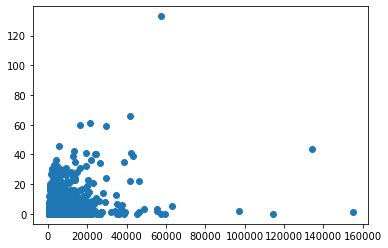

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.scatter(wiki_feat['days_since_creation'],wiki_feat['languages'])
#plt.scatter(wiki_feat['references'],wiki_feat['languages'])
plt.scatter(wiki_feat['text_length'],wiki_feat['languages'])
